In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split as sk_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
import datetime

# Load datasets
ratings = pd.read_csv('ml-latest/ratings.csv')
print ('Shape of the ratings data frame:', ratings.shape)

tags = pd.read_csv('ml-latest/tags.csv')
print ('Shape of the tags data frame:', tags.shape)

movies = pd.read_csv('ml-latest/movies.csv')
print ('Shape of the movies data frame:', movies.shape)

#Will take
tags = tags.sample(frac=0.2)
ratings = ratings.sample(frac=0.2)

print ('Shape of the sampled ratings data frame:', ratings.shape)
print ('Shape of the sampled tags data frame:', tags.shape)
print ('Shape of the sampled movies data frame:', movies.shape)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


('Shape of the ratings data frame:', (26024289, 4))
('Shape of the tags data frame:', (753170, 4))
('Shape of the movies data frame:', (45843, 3))
('Shape of the sampled ratings data frame:', (5204858, 4))
('Shape of the sampled tags data frame:', (150634, 4))
('Shape of the sampled movies data frame:', (45843, 3))


In [4]:
#Print sample ratings data
ratings = ratings.drop(['timestamp'],axis=1)
ratings.head(n=5)

,userId,movieId,rating
7964205,82083,262,4.0
1035847,10555,555,3.0
1964942,20430,7669,3.5
1015832,10336,1097,5.0
21221252,220418,2,4.0


In [5]:
#Display summary statistics about data
ratings.describe()

,userId,movieId,rating
count,5.204858e+06,5.204858e+06,5.204858e+06
mean,1.350656e+05,1.584455e+04,3.527673e+00
std,7.816547e+04,3.108233e+04,1.065533e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,6.719100e+04,1.073000e+03,3.000000e+00
50%,1.352430e+05,2.581000e+03,3.500000e+00
75%,2.027260e+05,6.502000e+03,4.000000e+00
max,2.708960e+05,1.762730e+05,5.000000e+00


In [6]:
#Print sample tags data
tags.head(n=5)

,userId,movieId,tag,timestamp
546693,196358,6502,virus,1247860007
346311,128591,74795,Middle East,1290196816
315066,115995,34405,space,1282512337
67858,26737,170,hacking,1179268115
514523,185853,50,twist ending,1304002734


In [7]:
#Print sample movies data
movies.head(n=5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
data = pd.merge(ratings, tags, how='inner')
print ('Shape of the joint data frame:', data.shape)
print (data.head(n=5))

('Shape of the joint data frame:', (26088, 5))
   userId  movieId  rating                tag   timestamp
0  251765      541     5.0          film noir  1438575464
1  251765      541     5.0         futuristic  1438575452
2  251765      541     5.0     Philip K. Dick  1438575487
3  251765      541     5.0  visually striking  1438575510
4  251765      541     5.0           neo-noir  1438575474


## 清理数据

In [9]:
for column in data.columns:
    print (column, data[column].nunique())

('userId', 4092)
('movieId', 5544)
('rating', 10)
('tag', 7394)
('timestamp', 25701)


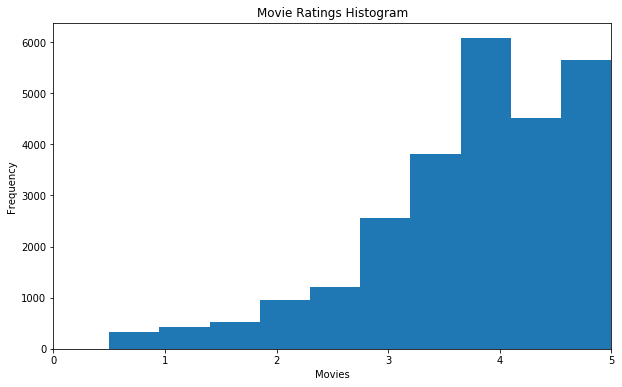

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.hist(data['rating'],10)
plt.xlabel('Movies'); 
plt.ylabel('Frequency')
plt.xlim(0,5)
plt.title('Movie Ratings Histogram')
plt.show()

最频繁的电影评分是4，这也导致了一个不平衡的目标变量，用平均评级来可视化标签


In [11]:
#Remove any special characters from tag
#Relabel ratings 
data['rating'] = data['rating'].apply(lambda x: 1 if x > 4 else 0)

#Delete special characters
data['tag'] = data['tag'].apply(lambda x: str(x))
data['tag'] = data['tag'].map(lambda x: re.sub(r'([^\s\w]|_)+', '', x))
data['tag'] = data['tag'].str.lower()
#Convert timestamp in seconds to datetime format
data['timestamp'] = data['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
data['timestamp'].astype('datetime64[ns]')[0:5]

0   2015-08-03 12:17:44
1   2015-08-03 12:17:32
2   2015-08-03 12:18:07
3   2015-08-03 12:18:30
4   2015-08-03 12:17:54
Name: timestamp, dtype: datetime64[ns]

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tag'])
sequences = tokenizer.texts_to_sequences(data['tag'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

pseq = pad_sequences(sequences)
pdseq = pd.DataFrame(pseq)

Using TensorFlow backend.


Found 6680 unique tokens.


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english',decode_error='ignore', analyzer='word')
corpus = data['tag'].values
wordvec = vectorizer.fit_transform(corpus.ravel())
wordvec = wordvec.toarray()

words = vectorizer.get_feature_names()
print("number of words in plot summary: ", len(words))
pdwordvec = pd.DataFrame(wordvec,columns=words)

('number of words in plot summary: ', 6501)


## 降维：K-Means Clustering Words using Glove Embeddings

- Load Stanford's global word 作为预先训练的模型

In [14]:
embeddings_index = {}
f = open('glove.6B/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(words), 100))
for i in xrange(len(words)):
    embedding_vector = embeddings_index.get(words[i])
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
pdembedding = pd.DataFrame(embedding_matrix.T,columns=words)

Found 400000 word vectors.


In [15]:
pdembedding[0:5]

,007,06,090106,10,100,1001,14th,150106,16th,1800s,...,zimmer,ziyi,zizek,zoe,zoeey,zombie,zombies,zombis,zooey,zwigoff
0,1.01850,-0.14966,0.0,0.086759,0.281330,0.508030,0.16295,0.0,0.089867,0.36931,...,0.099673,0.051288,-0.106850,0.875850,0.0,-0.33894,-0.15087,0.0,0.70692,0.37750
1,-0.41461,-0.32111,0.0,0.343100,0.752390,0.070279,-0.36031,0.0,-0.361430,0.34400,...,0.200100,0.658680,0.117320,-0.067071,0.0,0.29189,0.20890,0.0,0.63465,0.10591
2,1.25320,0.21657,0.0,0.015262,-0.055879,0.944470,0.85764,0.0,0.647830,-0.15759,...,-0.037968,0.651480,-0.091888,-0.323010,0.0,0.29925,0.75442,0.0,-0.45704,-0.71806
3,-0.03777,-0.62910,0.0,-0.211760,0.165300,0.222260,0.60448,0.0,0.529090,0.51441,...,-1.014900,-0.504470,0.228630,-0.640720,0.0,-0.65192,-0.81336,0.0,-0.77984,-0.41457
4,-0.20713,-0.22629,0.0,0.016745,0.312520,0.419850,0.55783,0.0,0.427850,-0.37421,...,-0.278860,0.415200,-0.451000,-0.161300,0.0,-0.45548,-0.20850,0.0,-0.62618,-0.28597


In [16]:
reduced_data = PCA(n_components=2,svd_solver='auto').fit_transform(pdembedding.T)
kmeans = KMeans(init='k-means++', n_clusters=100, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh
h =0.02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)


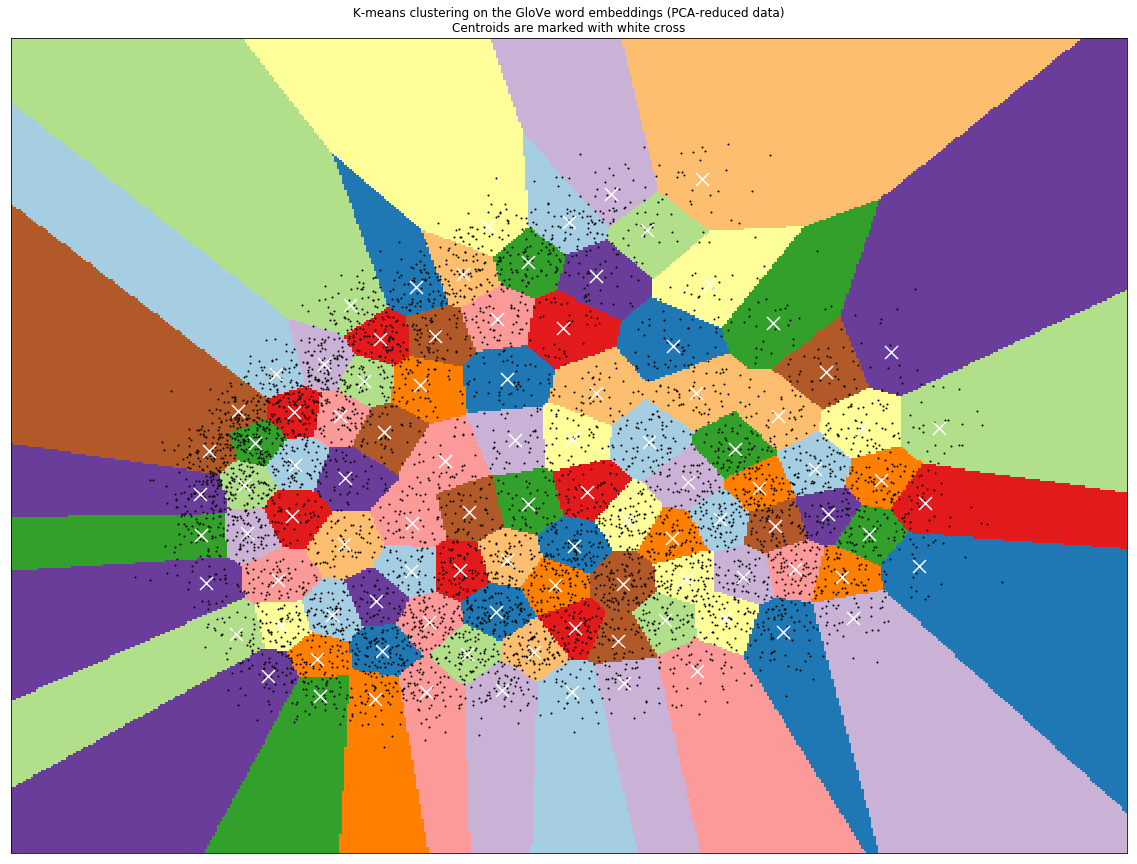

In [17]:
plt.figure(figsize=(20, 15))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the GloVe word embeddings (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

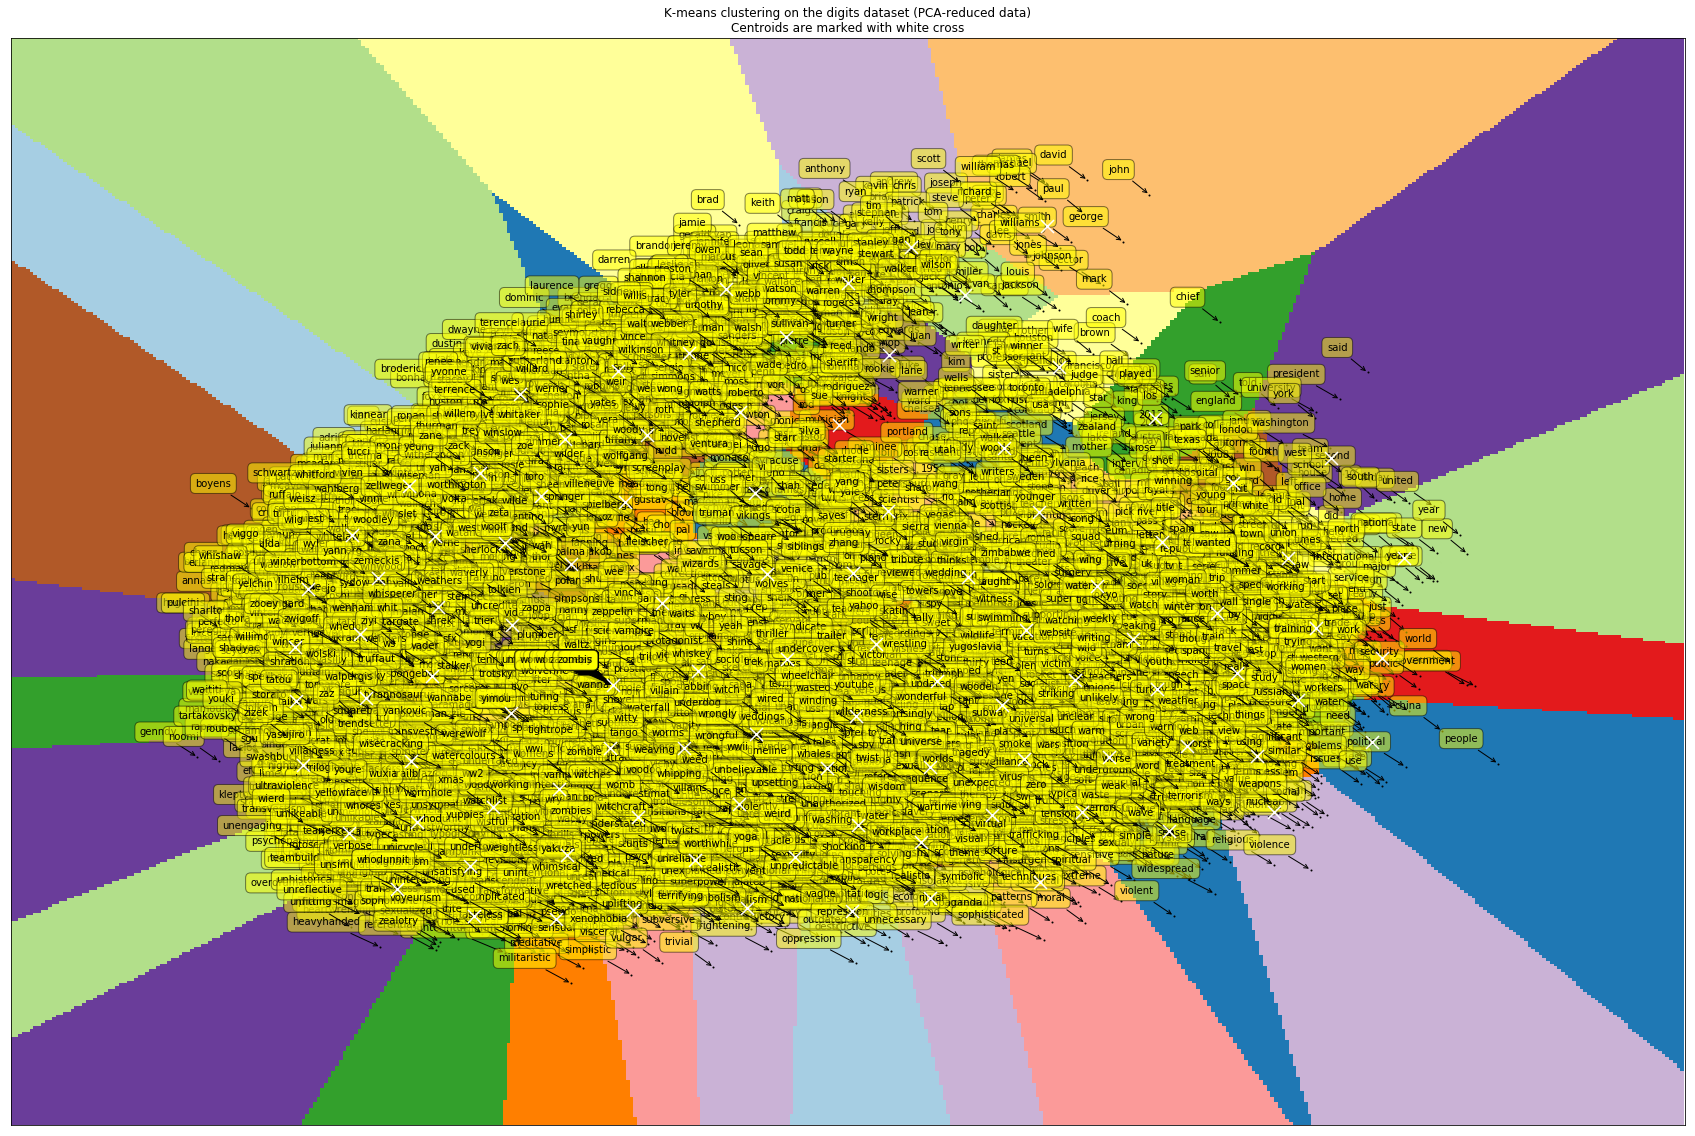

In [18]:
plt.figure(figsize=(30, 20))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', label=words,markersize=2)
for label, x, y in zip(words, reduced_data[:, 0], reduced_data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### Prepare data for Clustering

In [19]:
#Cluster word embeddings data 
kmeans = KMeans(init='k-means++', n_clusters=300, n_init=10)
kmeans.fit(pdembedding.T)
#Get cluster labels
clusters = kmeans.labels_

#Add columns to data for each cluster
for i in xrange(max(clusters)+1):
 data[i] = 0

#If word is in data row, label the associated cluster accordingly with 1
for i in xrange(len(pdwordvec.columns)):
    column = pdwordvec.columns[i]
    index = pdwordvec[column].loc[pdwordvec[column] > 0, ].index
    for ii in xrange(len(index)):
        data.loc[index[ii],clusters[i]] = 1

In [20]:
#Drop tag as we will use vectorized words
data = data.drop(['tag'], axis=1)

#Add genres
#Split genre column
genresplit = movies.set_index('movieId').genres.str.split(r'|', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')
#Use one-hot encoding grouped by genre 
genres = pd.get_dummies(genresplit, prefix='genre', columns=['genre']).groupby(level=0).sum()
#Drop unnecessary field, if all genres are 0 then it means no genres are listed. 
genres = genres.drop(['genre_(no genres listed)'], axis=1)
#Join data by movieId
genres['movieId'] = genres.index
data = pd.merge(data, genres, on='movieId', how='left')

#Assign variables as categorical using one hot encoding
useridencoding = pd.get_dummies(data['userId'], prefix='userid')
data = data.drop(['userId'], axis=1)
data = pd.concat([data, useridencoding], axis=1)

movieidencoding = pd.get_dummies(data['movieId'], prefix='movieid')
data = data.drop(['movieId'], axis=1)
data = pd.concat([data, movieidencoding], axis=1)
data = data.fillna(np.nan)

# Machine Learning Classification Models

选择了精确度作为关键指标

将在2016-2016年之前使用这些数据作为训练集，并使用剩下的12个月的数据作为测试集。

In [32]:
#Convert timestamp in seconds to datetime format
#train = data[(data['timestamp'] < '2016-11-01') ]
#test = data[(data['timestamp'] >= '2016-11-01') ]
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=0)
#随机选择20%作为测试集，剩余作为训练集
print "Number of rows in training data set:",(len(train))
print "Number of rows in test data set:", (len(test))

Number of rows in training data set: 20870
Number of rows in test data set: 5218


12 months of data with 4k cases will definitely provide a good model accuracy measure. 

In [33]:
#remove timestamp as it won't be needed for modeling
train = train.drop(['timestamp'], axis=1)
test = test.drop(['timestamp'], axis=1)

In [34]:
#Define target and predictor variables
y_train = train['rating']
y_test = test['rating']
x_train = train.drop(['rating'], axis=1)
x_test = test.drop(['rating'], axis=1)

In [35]:
#基准准确率线
baselineaccuracy = float(y_test.value_counts().max())/y_test.value_counts().sum()
print "Accuracy of the baseline model is: ", np.round(baselineaccuracy,4)

Accuracy of the baseline model is:  0.6135


## Logistic Regression Model

In [36]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C = 1, class_weight='balanced')
logreg.fit(x_train, y_train)
y_predlog = logreg.predict_proba(x_test)
R2_log = logreg.score(x_test,y_test) 
print "Accuracy of the test set for log. reg. is: ", np.round(R2_log,4)

Accuracy of the test set for log. reg. is:  0.7583


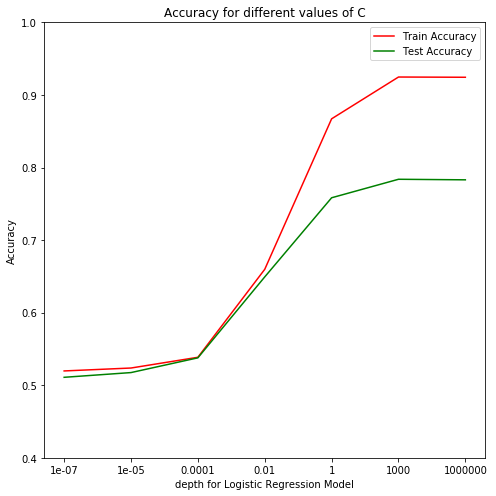

('Accuracy is maximum at depth', 1000, 'and accuracy', 0.7838)


In [42]:
depth = [0.0000001,0.00001,0.0001,0.01, 1, 1000, 1000000]

train_acc = []
test_acc = []

for i in depth:
    logit = LogisticRegression( C = i, class_weight='balanced')
    logit.fit(x_train, y_train)
    train_acc.append(logit.score(x_train, y_train))
    test_acc.append(logit.score(x_test, y_test))

#Visualize accuracy for different regularization parameters
plt.figure(figsize=(7,7))
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(test_acc, color='g', label='Test Accuracy')
plt.xticks(xrange(7), depth)
plt.xlabel('depth for Logistic Regression Model')
plt.ylabel('Accuracy')
plt.ylim(0.4,1)
plt.title('Accuracy for different values of C')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print('Accuracy is maximum at depth', depth[np.argmax(test_acc)],'and accuracy', round(max(test_acc), 4))


## Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(bootstrap=True, class_weight='balanced',criterion='gini',random_state=None,verbose=0, warm_start=False)
RFC.set_params(n_estimators=100)
RFC.fit(x_train,y_train)
R2_rfc = RFC.score(x_test,y_test) 
print "Accuracy of the test set for random forest is: ", np.round(R2_rfc,4)

Accuracy of the test set for random forest is:  0.7693


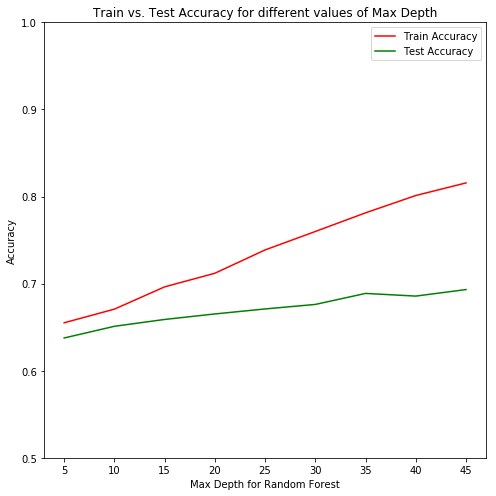

('Accuracy is maximum at max depth value of', 45, 'and yields accuracy of', 0.6932)


In [45]:
depth = xrange(5,50,5)
train_acc = []
test_acc = []

for i in depth:
    RFC.set_params(n_estimators=100, max_depth=i)
    RFC.fit(x_train, y_train)
    train_acc.append(RFC.score(x_train, y_train))
    test_acc.append(RFC.score(x_test, y_test))


#Visualize accuracy for different regularization parameters
plt.figure(figsize=(7,7))
plt.plot(train_acc, color='r', label='Train Accuracy')
plt.plot(test_acc, color='g', label='Test Accuracy')
plt.xticks(xrange(9), depth)
plt.xlabel('Max Depth for Random Forest')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.title('Train vs. Test Accuracy for different values of Max Depth')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print('Accuracy is maximum at max depth value of', depth[np.argmax(test_acc)],
                'and yields accuracy of', round(max(test_acc), 4))

In [95]:
importance = RFC.feature_importances_
importance = pd.DataFrame(importance, index=x_train.columns, 
                          columns=["Importance"])
importance["Std"] = np.std([tree.feature_importances_
                            for tree in RFC.estimators_], axis=0)

importance['Importance'].sort_values(ascending=False)[1:10]

genre_Drama        0.008004
genre_Thriller     0.007068
userid_78340       0.006642
genre_Comedy       0.006539
userid_76206       0.006234
genre_Romance      0.006174
genre_Sci-Fi       0.005989
userid_257255      0.005941
genre_Adventure    0.005865
Name: Importance, dtype: float64

In [215]:
importance[importance['Importance']==0].count()

Importance    2913
Std           2913
dtype: int64

In [222]:
clus = np.where(clusters==12)
clus = np.array(clus)
clus = pd.DataFrame(clus)
clussamp = clus.T.sample(10,replace=True)

clus = []
for index, row in clussamp.iterrows():
    clus.append(int(row.values))

for i in clus:
    print words[i]

scientology
religion
judaism
islam
christianity
scientology
scientology
christianity
scientology
judaism
judaism
catholicism
islam
christianity
scientology
religion
catholicism
islam
catholicism
scientology


In [38]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
NB.fit(x_train,y_train)
R2_nb = NB.score(x_test,y_test) 
print "Accuracy of the test set for Multinomial NB model is: ", np.round(R2_nb,4)

Accuracy of the test set for Multinomial NB model is:  0.758


In [40]:
from sklearn.ensemble import AdaBoostClassifier

AdaB = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=100, random_state=None)
AdaB.fit(x_train,y_train)
R2_ada = AdaB.score(x_test,y_test) 
print "Accuracy of the test set for AdaBoost model is: ", np.round(R2_ada,4)

Accuracy of the test set for AdaBoost model is:  0.6462


In [41]:
import xgboost as xgb

clf = xgb.XGBClassifier(max_depth=20, learning_rate=0.1) 
clf.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_train, y_train), (x_test, y_test)])  
R2_xgb = clf.score(x_test,y_test) 
print "Accuracy of the test set for XGBoost model is: ", np.round(R2_xgb,4)

[0]	validation_0-error:0.357355	validation_1-error:0.361058
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.356876	validation_1-error:0.361824
[2]	validation_0-error:0.353138	validation_1-error:0.35665
[3]	validation_0-error:0.355343	validation_1-error:0.360866
[4]	validation_0-error:0.352372	validation_1-error:0.357608
[5]	validation_0-error:0.34667	validation_1-error:0.356458
[6]	validation_0-error:0.344562	validation_1-error:0.357608
[7]	validation_0-error:0.346814	validation_1-error:0.357033
[8]	validation_0-error:0.345137	validation_1-error:0.3555
[9]	validation_0-error:0.345328	validation_1-error:0.355883
[10]	validation_0-error:0.338716	validation_1-error:0.351092
[11]	validation_0-error:0.336128	validation_1-error:0.349751
[12]	validation_0-error:0.335841	validation_1-error:0.348984
[13]	validation_0-error:0.334451	validation_1-error:0.351092